In [1]:
import pandas as pd
import seaborn as sns # data visualization library  
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt 
import math
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)

seed = 7
np.random.seed(seed)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
TIME_STEPS = 12

def process(filename) :
    features = pd.read_csv(filename, index_col=[0])
    features.fillna(method='ffill', inplace=True)
    
    features['week_start_date'] = pd.to_datetime(features['week_start_date']).astype(np.int64) // 10**9
    cols = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'precipitation_amt_mm', 'week_start_date']
    
    features = features[cols]
    features = features.astype('float32')
    
    for i in range(1, TIME_STEPS): 
        for col in cols:
            features[col + '_prev_' + str(i)] = features[col].shift(-i)
    features.fillna(method='ffill', inplace=True)
    
    return features

In [21]:
SJ_DIVIDE_FACTOR = 300
IQ_DIVIDE_FACTOR = 100

train_feature_filename = "dengue_features_train.csv"
train_label_filename = "dengue_labels_train.csv"

test_feature_filename = "dengue_features_test.csv"

train_features = process(train_feature_filename)
test_features = process(test_feature_filename)

train_labels = pd.read_csv(train_label_filename, index_col=[0])
train_labels = train_labels.drop(['year', 'weekofyear'], axis=1)
train_labels = train_labels.astype('float32')

# train_labels['total_cases'] = train_labels['total_cases'].apply(lambda c : c / DIVIDE_FACTOR)

# for obs in range(1, 2):
#     train_features["T_" + str(obs)] = train_labels.total_cases.shift(obs)

# train_features.fillna(0.00, inplace=True)


test_features.tail()
# train_labels.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,precipitation_amt_mm,week_start_date,reanalysis_specific_humidity_g_per_kg_prev_1,reanalysis_dew_point_temp_k_prev_1,station_avg_temp_c_prev_1,precipitation_amt_mm_prev_1,week_start_date_prev_1,reanalysis_specific_humidity_g_per_kg_prev_2,reanalysis_dew_point_temp_k_prev_2,station_avg_temp_c_prev_2,precipitation_amt_mm_prev_2,week_start_date_prev_2,reanalysis_specific_humidity_g_per_kg_prev_3,reanalysis_dew_point_temp_k_prev_3,station_avg_temp_c_prev_3,precipitation_amt_mm_prev_3,week_start_date_prev_3,reanalysis_specific_humidity_g_per_kg_prev_4,reanalysis_dew_point_temp_k_prev_4,station_avg_temp_c_prev_4,precipitation_amt_mm_prev_4,week_start_date_prev_4,...,reanalysis_specific_humidity_g_per_kg_prev_7,reanalysis_dew_point_temp_k_prev_7,station_avg_temp_c_prev_7,precipitation_amt_mm_prev_7,week_start_date_prev_7,reanalysis_specific_humidity_g_per_kg_prev_8,reanalysis_dew_point_temp_k_prev_8,station_avg_temp_c_prev_8,precipitation_amt_mm_prev_8,week_start_date_prev_8,reanalysis_specific_humidity_g_per_kg_prev_9,reanalysis_dew_point_temp_k_prev_9,station_avg_temp_c_prev_9,precipitation_amt_mm_prev_9,week_start_date_prev_9,reanalysis_specific_humidity_g_per_kg_prev_10,reanalysis_dew_point_temp_k_prev_10,station_avg_temp_c_prev_10,precipitation_amt_mm_prev_10,week_start_date_prev_10,reanalysis_specific_humidity_g_per_kg_prev_11,reanalysis_dew_point_temp_k_prev_11,station_avg_temp_c_prev_11,precipitation_amt_mm_prev_11,week_start_date_prev_11
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
iq,17.185715,295.638580,27.400000,41.119999,1.369699e+09,17.448572,295.845703,27.520000,71.519997,1.370304e+09,16.410000,294.894287,27.200001,78.959999,1.370909e+09,15.137143,293.648560,26.700001,39.540001,1.371514e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,...,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09
iq,17.448572,295.845703,27.520000,71.519997,1.370304e+09,16.410000,294.894287,27.200001,78.959999,1.370909e+09,15.137143,293.648560,26.700001,39.540001,1.371514e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,...,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09
iq,16.410000,294.894287,27.200001,78.959999,1.370909e+09,15.137143,293.648560,26.700001,39.540001,1.371514e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,...,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09
iq,15.137143,293.648560,26.700001,39.540001,1.371514e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,...,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09
iq,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.350000,51.799999,1.372118e+09,16.148571,294.615723,27.35,51.799999,1.372118e+09,...,16.148571,294.615723,27.35,51

In [22]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj'].apply(lambda c : c / SJ_DIVIDE_FACTOR)

sj_test_features = test_features.loc['sj']
sj_test_labels = test_features.loc['sj'].apply(lambda c : c / SJ_DIVIDE_FACTOR)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq'].apply(lambda c : c / IQ_DIVIDE_FACTOR)

iq_test_features = test_features.loc['iq']
iq_test_labels = test_features.loc['iq'].apply(lambda c : c / IQ_DIVIDE_FACTOR)

# sj_train_features.head()

# normalize the dataset
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# sj_train_labels = sj_train_labels.reset_index().drop(['weekofyear', 'year'], axis=1)
# iq_train_labels = iq_train_labels.reset_index().drop(['weekofyear', 'year'], axis=1)

sj_train_features = scaler_features.fit_transform(sj_train_features)
# sj_train_labels = scaler_labels.fit_transform(sj_train_labels)
iq_train_features = scaler_features.fit_transform(iq_train_features)
# iq_train_labels = scaler_labels.fit_transform(iq_train_labels)


sj_test_features = scaler_features.fit_transform(sj_test_features)
iq_test_features = scaler_features.fit_transform(iq_test_features)

# sj_train_labels = np.delete(sj_train_labels, 0, 1)
# sj_train_labels



In [23]:
iq_train_labels.tail()

,total_cases
city,
iq,0.05
iq,0.08
iq,0.01
iq,0.01
iq,0.04


In [24]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train_features, sj_train_labels, test_size=0.25, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train_features, iq_train_labels, test_size=0.25, random_state=0, shuffle=False)

# sj_train_X

In [25]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train_features, sj_train_labels, test_size=0.25, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train_features, iq_train_labels, test_size=0.25, random_state=0, shuffle=False)

# sj_train_X


# # convert an array of values into a dataset matrix
# def create_dataset(x, y, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(x)-look_back-1):
#         a = x[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(y[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
# look_back = 1
# sj_trainX, sj_trainY = create_dataset(sj_train_X, sj_train_y, look_back)
# sj_testX, sj_testY = create_dataset(sj_test_X, sj_test_y, look_back)

# sj_train_X.shape

# reshape X to be [samples, time steps, features]
sj_train_X = np.array(sj_train_X).reshape(sj_train_X.shape[0], TIME_STEPS, sj_train_X.shape[1] / TIME_STEPS)
sj_test_X = np.array(sj_test_X).reshape(sj_test_X.shape[0], TIME_STEPS, sj_test_X.shape[1] / TIME_STEPS)

sj_test = np.array(sj_test_features).reshape(sj_test_features.shape[0], TIME_STEPS, sj_test_features.shape[1] / TIME_STEPS)
# sj_test_features.shape


# reshape X to be [samples, time steps, features]
iq_train_X = np.array(iq_train_X).reshape(iq_train_X.shape[0], TIME_STEPS, iq_train_X.shape[1] / TIME_STEPS)
iq_test_X = np.array(iq_test_X).reshape(iq_test_X.shape[0], TIME_STEPS, iq_test_X.shape[1] / TIME_STEPS)

iq_test = np.array(iq_test_features).reshape(iq_test_features.shape[0], TIME_STEPS, iq_test_features.shape[1] / TIME_STEPS)

In [35]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# create and fit the LSTM network
sj_model = Sequential()

# stateful LSTM
# batch_size = 1
# sj_model.add(LSTM(16, batch_input_shape=(batch_size, sj_train_X.shape[1], sj_train_X.shape[2]), stateful=True))

sj_model.add(LSTM(units=32, input_shape=(sj_train_X.shape[1], sj_train_X.shape[2]), return_sequences=False))
sj_model.add(Dense(output_dim=1))

sj_model.compile(loss='mae', optimizer=adam, metrics=["accuracy"])
hist = sj_model.fit(sj_train_X, sj_train_y, epochs=300, batch_size=256, verbose=2,
          validation_data=(sj_test_X, sj_test_y), shuffle=False)


# losses = []
# val_losses = []
# for i in range(300):
#     hist = sj_model.fit(sj_train_X, sj_train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False,
#                 validation_data=(sj_test_X, sj_test_y))
#     losses.append(hist.history['loss'][0])
#     val_losses.append(hist.history['val_loss'][0])
#     sj_model.reset_states()

# plt.plot(losses, label='train_loss')
# plt.plot(val_losses, label='val_loss')
# plt.legend()
# plt.show()
    
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  del sys.path[0]


Train on 702 samples, validate on 234 samples
Epoch 1/300
 - 1s - loss: 0.1025 - acc: 0.0043 - val_loss: 0.0750 - val_acc: 0.0043
Epoch 2/300
 - 0s - loss: 0.1025 - acc: 0.0043 - val_loss: 0.0750 - val_acc: 0.0043
Epoch 3/300
 - 0s - loss: 0.1025 - acc: 0.0043 - val_loss: 0.0749 - val_acc: 0.0043
Epoch 4/300
 - 0s - loss: 0.1024 - acc: 0.0043 - val_loss: 0.0749 - val_acc: 0.0043
Epoch 5/300
 - 0s - loss: 0.1024 - acc: 0.0043 - val_loss: 0.0748 - val_acc: 0.0043
Epoch 6/300
 - 0s - loss: 0.1024 - acc: 0.0043 - val_loss: 0.0747 - val_acc: 0.0043
Epoch 7/300
 - 0s - loss: 0.1023 - acc: 0.0043 - val_loss: 0.0747 - val_acc: 0.0043
Epoch 8/300
 - 0s - loss: 0.1023 - acc: 0.0043 - val_loss: 0.0746 - val_acc: 0.0043
Epoch 9/300
 - 0s - loss: 0.1023 - acc: 0.0043 - val_loss: 0.0745 - val_acc: 0.0043
Epoch 10/300
 - 0s - loss: 0.1022 - acc: 0.0043 - val_loss: 0.0745 - val_acc: 0.0043
Epoch 11/300
 - 0s - loss: 0.1022 - acc: 0.0043 - val_loss: 0.0744 - val_acc: 0.0043
Epoch 12/300
 - 0s - loss: 0

Epoch 97/300
 - 0s - loss: 0.0998 - acc: 0.0043 - val_loss: 0.0695 - val_acc: 0.0043
Epoch 98/300
 - 0s - loss: 0.0998 - acc: 0.0043 - val_loss: 0.0694 - val_acc: 0.0043
Epoch 99/300
 - 0s - loss: 0.0997 - acc: 0.0043 - val_loss: 0.0694 - val_acc: 0.0043
Epoch 100/300
 - 0s - loss: 0.0997 - acc: 0.0043 - val_loss: 0.0693 - val_acc: 0.0043
Epoch 101/300
 - 0s - loss: 0.0997 - acc: 0.0043 - val_loss: 0.0693 - val_acc: 0.0043
Epoch 102/300
 - 0s - loss: 0.0997 - acc: 0.0043 - val_loss: 0.0692 - val_acc: 0.0043
Epoch 103/300
 - 0s - loss: 0.0996 - acc: 0.0043 - val_loss: 0.0692 - val_acc: 0.0043
Epoch 104/300
 - 0s - loss: 0.0996 - acc: 0.0043 - val_loss: 0.0691 - val_acc: 0.0043
Epoch 105/300
 - 0s - loss: 0.0996 - acc: 0.0043 - val_loss: 0.0691 - val_acc: 0.0043
Epoch 106/300
 - 0s - loss: 0.0996 - acc: 0.0043 - val_loss: 0.0690 - val_acc: 0.0043
Epoch 107/300
 - 0s - loss: 0.0995 - acc: 0.0043 - val_loss: 0.0690 - val_acc: 0.0043
Epoch 108/300
 - 0s - loss: 0.0995 - acc: 0.0043 - val_lo

KeyboardInterrupt: 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if __name__ == '__main__':


Train on 390 samples, validate on 130 samples
Epoch 1/1000
 - 1s - loss: 0.0104 - acc: 0.2179 - val_loss: 0.0165 - val_acc: 0.0846
Epoch 2/1000
 - 0s - loss: 0.0103 - acc: 0.2179 - val_loss: 0.0163 - val_acc: 0.0846
Epoch 3/1000
 - 0s - loss: 0.0101 - acc: 0.2179 - val_loss: 0.0162 - val_acc: 0.0846
Epoch 4/1000
 - 0s - loss: 0.0098 - acc: 0.2179 - val_loss: 0.0164 - val_acc: 0.0846
Epoch 5/1000
 - 0s - loss: 0.0097 - acc: 0.2179 - val_loss: 0.0163 - val_acc: 0.0846
Epoch 6/1000
 - 0s - loss: 0.0097 - acc: 0.2179 - val_loss: 0.0158 - val_acc: 0.0846
Epoch 7/1000
 - 0s - loss: 0.0096 - acc: 0.2179 - val_loss: 0.0154 - val_acc: 0.0846
Epoch 8/1000
 - 0s - loss: 0.0094 - acc: 0.2179 - val_loss: 0.0154 - val_acc: 0.0846
Epoch 9/1000
 - 0s - loss: 0.0093 - acc: 0.2179 - val_loss: 0.0155 - val_acc: 0.0846
Epoch 10/1000
 - 0s - loss: 0.0094 - acc: 0.2179 - val_loss: 0.0155 - val_acc: 0.0846
Epoch 11/1000
 - 0s - loss: 0.0093 - acc: 0.2179 - val_loss: 0.0152 - val_acc: 0.0846
Epoch 12/1000
 - 

Epoch 96/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0166 - val_acc: 0.0846
Epoch 97/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0167 - val_acc: 0.0846
Epoch 98/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0167 - val_acc: 0.0846
Epoch 99/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0167 - val_acc: 0.0846
Epoch 100/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0167 - val_acc: 0.0846
Epoch 101/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 102/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 103/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 104/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 105/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 106/1000
 - 0s - loss: 0.0082 - acc: 0.2179 - val_loss: 0.0168 - val_acc: 0.0846
Epoch 107/1000
 - 0s - loss: 0.0082 - acc: 0.21

Epoch 191/1000
 - 0s - loss: 0.0074 - acc: 0.2179 - val_loss: 0.0179 - val_acc: 0.0846
Epoch 192/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0176 - val_acc: 0.0846
Epoch 193/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0178 - val_acc: 0.0846
Epoch 194/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0177 - val_acc: 0.0846
Epoch 195/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0176 - val_acc: 0.0846
Epoch 196/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0178 - val_acc: 0.0846
Epoch 197/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0175 - val_acc: 0.0846
Epoch 198/1000
 - 0s - loss: 0.0072 - acc: 0.2179 - val_loss: 0.0179 - val_acc: 0.0846
Epoch 199/1000
 - 0s - loss: 0.0072 - acc: 0.2179 - val_loss: 0.0173 - val_acc: 0.0846
Epoch 200/1000
 - 0s - loss: 0.0072 - acc: 0.2179 - val_loss: 0.0182 - val_acc: 0.0846
Epoch 201/1000
 - 0s - loss: 0.0073 - acc: 0.2179 - val_loss: 0.0170 - val_acc: 0.0846
Epoch 202/1000
 - 0s - loss: 0.0072 - acc: 

 - 0s - loss: 0.0057 - acc: 0.2179 - val_loss: 0.0200 - val_acc: 0.0846
Epoch 286/1000
 - 0s - loss: 0.0057 - acc: 0.2179 - val_loss: 0.0198 - val_acc: 0.0846
Epoch 287/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0198 - val_acc: 0.0846
Epoch 288/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0199 - val_acc: 0.0846
Epoch 289/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0200 - val_acc: 0.0846
Epoch 290/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0198 - val_acc: 0.0846
Epoch 291/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0198 - val_acc: 0.0846
Epoch 292/1000
 - 0s - loss: 0.0057 - acc: 0.2179 - val_loss: 0.0199 - val_acc: 0.0846
Epoch 293/1000
 - 0s - loss: 0.0060 - acc: 0.2179 - val_loss: 0.0199 - val_acc: 0.0846
Epoch 294/1000
 - 0s - loss: 0.0058 - acc: 0.2179 - val_loss: 0.0205 - val_acc: 0.0846
Epoch 295/1000
 - 0s - loss: 0.0056 - acc: 0.2179 - val_loss: 0.0205 - val_acc: 0.0846
Epoch 296/1000
 - 0s - loss: 0.0055 - acc: 0.2179 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0040 - acc: 0.2179 - val_loss: 0.0212 - val_acc: 0.0846
Epoch 381/1000
 - 0s - loss: 0.0041 - acc: 0.2179 - val_loss: 0.0239 - val_acc: 0.0846
Epoch 382/1000
 - 0s - loss: 0.0044 - acc: 0.2179 - val_loss: 0.0251 - val_acc: 0.0846
Epoch 383/1000
 - 0s - loss: 0.0041 - acc: 0.2179 - val_loss: 0.0220 - val_acc: 0.0846
Epoch 384/1000
 - 0s - loss: 0.0039 - acc: 0.2179 - val_loss: 0.0202 - val_acc: 0.0846
Epoch 385/1000
 - 0s - loss: 0.0040 - acc: 0.2179 - val_loss: 0.0218 - val_acc: 0.0846
Epoch 386/1000
 - 0s - loss: 0.0041 - acc: 0.2179 - val_loss: 0.0233 - val_acc: 0.0846
Epoch 387/1000
 - 0s - loss: 0.0042 - acc: 0.2179 - val_loss: 0.0231 - val_acc: 0.0846
Epoch 388/1000
 - 0s - loss: 0.0039 - acc: 0.2179 - val_loss: 0.0213 - val_acc: 0.0846
Epoch 389/1000
 - 0s - loss: 0.0038 - acc: 0.2179 - val_loss: 0.0214 - val_acc: 0.0846
Epoch 390/1000
 - 0s - loss: 0.0039 - acc: 0.2179 - val_loss: 0.0230 - val_acc: 0.0846
Epoch 391/1000
 - 0s - loss: 0.0040 - acc: 

 - 0s - loss: 0.0034 - acc: 0.2179 - val_loss: 0.0240 - val_acc: 0.0846
Epoch 475/1000
 - 0s - loss: 0.0035 - acc: 0.2179 - val_loss: 0.0244 - val_acc: 0.0846
Epoch 476/1000
 - 0s - loss: 0.0035 - acc: 0.2179 - val_loss: 0.0244 - val_acc: 0.0846
Epoch 477/1000
 - 0s - loss: 0.0035 - acc: 0.2179 - val_loss: 0.0249 - val_acc: 0.0846
Epoch 478/1000
 - 0s - loss: 0.0035 - acc: 0.2179 - val_loss: 0.0247 - val_acc: 0.0846
Epoch 479/1000
 - 0s - loss: 0.0034 - acc: 0.2179 - val_loss: 0.0249 - val_acc: 0.0846
Epoch 480/1000
 - 0s - loss: 0.0034 - acc: 0.2179 - val_loss: 0.0249 - val_acc: 0.0846
Epoch 481/1000
 - 0s - loss: 0.0033 - acc: 0.2179 - val_loss: 0.0248 - val_acc: 0.0846
Epoch 482/1000
 - 0s - loss: 0.0032 - acc: 0.2179 - val_loss: 0.0245 - val_acc: 0.0846
Epoch 483/1000
 - 0s - loss: 0.0032 - acc: 0.2179 - val_loss: 0.0242 - val_acc: 0.0846
Epoch 484/1000
 - 0s - loss: 0.0032 - acc: 0.2179 - val_loss: 0.0243 - val_acc: 0.0846
Epoch 485/1000
 - 0s - loss: 0.0033 - acc: 0.2179 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0028 - acc: 0.2179 - val_loss: 0.0275 - val_acc: 0.0846
Epoch 570/1000
 - 0s - loss: 0.0030 - acc: 0.2179 - val_loss: 0.0270 - val_acc: 0.0846
Epoch 571/1000
 - 0s - loss: 0.0032 - acc: 0.2179 - val_loss: 0.0262 - val_acc: 0.0846
Epoch 572/1000
 - 0s - loss: 0.0033 - acc: 0.2179 - val_loss: 0.0268 - val_acc: 0.0846
Epoch 573/1000
 - 0s - loss: 0.0035 - acc: 0.2179 - val_loss: 0.0269 - val_acc: 0.0846
Epoch 574/1000
 - 0s - loss: 0.0030 - acc: 0.2179 - val_loss: 0.0275 - val_acc: 0.0846
Epoch 575/1000
 - 0s - loss: 0.0028 - acc: 0.2179 - val_loss: 0.0277 - val_acc: 0.0846
Epoch 576/1000
 - 0s - loss: 0.0028 - acc: 0.2179 - val_loss: 0.0274 - val_acc: 0.0846
Epoch 577/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0271 - val_acc: 0.0846
Epoch 578/1000
 - 0s - loss: 0.0032 - acc: 0.2179 - val_loss: 0.0266 - val_acc: 0.0846
Epoch 579/1000
 - 0s - loss: 0.0033 - acc: 0.2179 - val_loss: 0.0271 - val_acc: 0.0846
Epoch 580/1000
 - 0s - loss: 0.0034 - acc: 

 - 0s - loss: 0.0028 - acc: 0.2179 - val_loss: 0.0291 - val_acc: 0.0846
Epoch 664/1000
 - 0s - loss: 0.0038 - acc: 0.2179 - val_loss: 0.0319 - val_acc: 0.0846
Epoch 665/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0329 - val_acc: 0.0846
Epoch 666/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0306 - val_acc: 0.0846
Epoch 667/1000
 - 0s - loss: 0.0034 - acc: 0.2179 - val_loss: 0.0284 - val_acc: 0.0846
Epoch 668/1000
 - 0s - loss: 0.0027 - acc: 0.2179 - val_loss: 0.0277 - val_acc: 0.0846
Epoch 669/1000
 - 0s - loss: 0.0030 - acc: 0.2179 - val_loss: 0.0282 - val_acc: 0.0846
Epoch 670/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0297 - val_acc: 0.0846
Epoch 671/1000
 - 0s - loss: 0.0026 - acc: 0.2179 - val_loss: 0.0304 - val_acc: 0.0846
Epoch 672/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0297 - val_acc: 0.0846
Epoch 673/1000
 - 0s - loss: 0.0027 - acc: 0.2179 - val_loss: 0.0298 - val_acc: 0.0846
Epoch 674/1000
 - 0s - loss: 0.0026 - acc: 0.2179 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0023 - acc: 0.2179 - val_loss: 0.0322 - val_acc: 0.0846
Epoch 759/1000
 - 0s - loss: 0.0022 - acc: 0.2179 - val_loss: 0.0323 - val_acc: 0.0846
Epoch 760/1000
 - 0s - loss: 0.0022 - acc: 0.2179 - val_loss: 0.0322 - val_acc: 0.0846
Epoch 761/1000
 - 0s - loss: 0.0023 - acc: 0.2179 - val_loss: 0.0317 - val_acc: 0.0846
Epoch 762/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_loss: 0.0320 - val_acc: 0.0846
Epoch 763/1000
 - 0s - loss: 0.0026 - acc: 0.2179 - val_loss: 0.0314 - val_acc: 0.0846
Epoch 764/1000
 - 0s - loss: 0.0027 - acc: 0.2179 - val_loss: 0.0320 - val_acc: 0.0846
Epoch 765/1000
 - 0s - loss: 0.0028 - acc: 0.2179 - val_loss: 0.0313 - val_acc: 0.0846
Epoch 766/1000
 - 0s - loss: 0.0025 - acc: 0.2179 - val_loss: 0.0317 - val_acc: 0.0846
Epoch 767/1000
 - 0s - loss: 0.0023 - acc: 0.2179 - val_loss: 0.0321 - val_acc: 0.0846
Epoch 768/1000
 - 0s - loss: 0.0022 - acc: 0.2179 - val_loss: 0.0321 - val_acc: 0.0846
Epoch 769/1000
 - 0s - loss: 0.0023 - acc: 

 - 0s - loss: 0.0021 - acc: 0.2179 - val_loss: 0.0342 - val_acc: 0.0846
Epoch 853/1000
 - 0s - loss: 0.0023 - acc: 0.2179 - val_loss: 0.0351 - val_acc: 0.0846
Epoch 854/1000
 - 0s - loss: 0.0025 - acc: 0.2179 - val_loss: 0.0342 - val_acc: 0.0846
Epoch 855/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_loss: 0.0350 - val_acc: 0.0846
Epoch 856/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_loss: 0.0341 - val_acc: 0.0846
Epoch 857/1000
 - 0s - loss: 0.0022 - acc: 0.2179 - val_loss: 0.0346 - val_acc: 0.0846
Epoch 858/1000
 - 0s - loss: 0.0020 - acc: 0.2179 - val_loss: 0.0346 - val_acc: 0.0846
Epoch 859/1000
 - 0s - loss: 0.0020 - acc: 0.2179 - val_loss: 0.0344 - val_acc: 0.0846
Epoch 860/1000
 - 0s - loss: 0.0021 - acc: 0.2179 - val_loss: 0.0350 - val_acc: 0.0846
Epoch 861/1000
 - 0s - loss: 0.0022 - acc: 0.2179 - val_loss: 0.0344 - val_acc: 0.0846
Epoch 862/1000
 - 0s - loss: 0.0023 - acc: 0.2179 - val_loss: 0.0352 - val_acc: 0.0846
Epoch 863/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_loss: 0.0373 - val_acc: 0.0846
Epoch 948/1000
 - 0s - loss: 0.0029 - acc: 0.2179 - val_loss: 0.0355 - val_acc: 0.0846
Epoch 949/1000
 - 0s - loss: 0.0021 - acc: 0.2179 - val_loss: 0.0364 - val_acc: 0.0846
Epoch 950/1000
 - 0s - loss: 0.0018 - acc: 0.2179 - val_loss: 0.0370 - val_acc: 0.0846
Epoch 951/1000
 - 0s - loss: 0.0019 - acc: 0.2179 - val_loss: 0.0362 - val_acc: 0.0846
Epoch 952/1000
 - 0s - loss: 0.0024 - acc: 0.2179 - val_loss: 0.0380 - val_acc: 0.0846
Epoch 953/1000
 - 0s - loss: 0.0033 - acc: 0.2179 - val_loss: 0.0356 - val_acc: 0.0846
Epoch 954/1000
 - 0s - loss: 0.0019 - acc: 0.2179 - val_loss: 0.0356 - val_acc: 0.0846
Epoch 955/1000
 - 0s - loss: 0.0021 - acc: 0.2179 - val_loss: 0.0381 - val_acc: 0.0846
Epoch 956/1000
 - 0s - loss: 0.0034 - acc: 0.2179 - val_loss: 0.0359 - val_acc: 0.0846
Epoch 957/1000
 - 0s - loss: 0.0019 - acc: 0.2179 - val_loss: 0.0351 - val_acc: 0.0846
Epoch 958/1000
 - 0s - loss: 0.0026 - acc: 

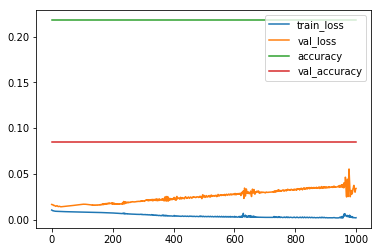

In [29]:
# create and fit the LSTM network
iq_model = Sequential()

# stateful LSTM
# batch_size = 1
# sj_model.add(LSTM(16, batch_input_shape=(batch_size, sj_train_X.shape[1], sj_train_X.shape[2]), stateful=True))

iq_model.add(LSTM(units=32, input_shape=(iq_train_X.shape[1], iq_train_X.shape[2]), return_sequences=False))
iq_model.add(Dense(output_dim=1))

iq_model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
hist = iq_model.fit(iq_train_X, iq_train_y, epochs=1000, batch_size=len(iq_train_X), verbose=2,
          validation_data=(iq_test_X, iq_test_y), shuffle=False)


# losses = []
# val_losses = []
# for i in range(300):
#     hist = sj_model.fit(sj_train_X, sj_train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False,
#                 validation_data=(sj_test_X, sj_test_y))
#     losses.append(hist.history['loss'][0])
#     val_losses.append(hist.history['val_loss'][0])
#     sj_model.reset_states()

# plt.plot(losses, label='train_loss')
# plt.plot(val_losses, label='val_loss')
# plt.legend()
# plt.show()
    
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()


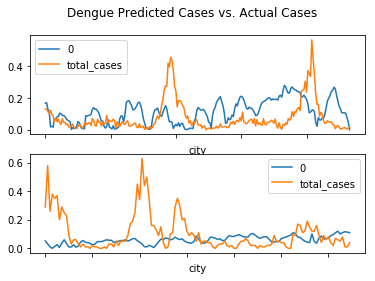

In [27]:
figs, axes = plt.subplots(nrows=2, ncols=1)

sj_pred_val = sj_model.predict(sj_test_X)
iq_pred_val = iq_model.predict(iq_test_X)

# plot sj
# sj_pred_val = []
# for x in sj_test_X:
#     x = np.reshape(x, (1, x.shape[0], x.shape[1]))
#     pred = sj_model.predict(x)
#     sj_pred_val.append(pred[0])

sj_pred_val = pd.DataFrame(sj_pred_val).apply(lambda x : ((x * x)**0.5))
sj_pred_val.plot(ax=axes[0], label="Predictions")
sj_test_y.plot(ax=axes[0], label="Actual")

# plot iq
iq_pred_val = pd.DataFrame(iq_pred_val).apply(lambda x : ((x * x)**0.5))
iq_pred_val.plot(ax=axes[1], label="Predictions")
iq_test_y.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()


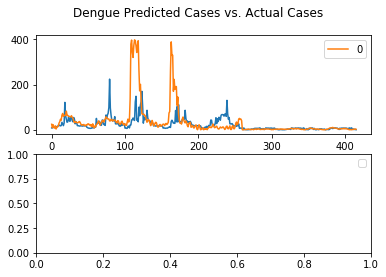

In [12]:
sj_pred = sj_model.predict(sj_test)
sj_pred = pd.DataFrame(sj_pred)
sj_pred = sj_pred.apply(lambda x : ((x * x)**0.5) * SJ_DIVIDE_FACTOR).astype(int)

iq_pred = iq_model.predict(iq_test)
iq_pred = pd.DataFrame(iq_pred)
iq_pred = iq_pred.apply(lambda x : ((x * x)**0.5) * IQ_DIVIDE_FACTOR).astype(int)
pred_arr = np.concatenate([sj_pred, iq_pred])
pred = pd.DataFrame(pred_arr)
# minn = sj_pred.min()
# maxx = sj_pred.max()
# dx = (maxx - minn)[0]
# dx
# sj_pred = sj_pred.apply(lambda x : 10 * x / dx).astype(int)
# sj_pred
benchmark = pd.read_csv('submission_23.9.csv')

figs, axes = plt.subplots(nrows=2, ncols=1)

benchmark.total_cases.plot(ax=axes[0], label="Predictions")
pred.plot(ax=axes[0], label="Actual")
    
plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

plt.show()

# # # print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, sj_pred)))

submission = pd.read_csv('submission_format.csv', index_col=[0, 1, 2])

submission.total_cases = pred_arr

submission.to_csv("submission_lstm.csv")
